# Summary

This notebook contains the data visualisations and predictions used in the presentation of the project. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style="darkgrid")
import matplotlib.pyplot as plt

import csv

from game_name_converter import NameConverter

from recomm_func import kNNMeans_Recommender

In [2]:
name_converter = NameConverter('games_master_list.csv')

# Data

In this section, we create visuals and display main statistics of the database used. 

In [3]:
df = pd.read_csv('./data_input/games_100_summary.csv', header = None, names = ['user_name', 'game_id', 'rating'])
df['game_name'] = df['game_id'].map(name_converter.get_game_name_from_id)

In [4]:
len(df)

2369886

## by Game

Analysing ratings by game, first the average ratings, and then the total number of ratings. 

In [13]:
avg_ratings_by_game = df.groupby('game_name').mean()['rating'].copy()
avg_ratings_by_game.sort_values(inplace = True)

As we can see in the chart below, average ratings of the games are very close, between 7 and 9. This was expected, we gathered the top 100 games by ratings. 

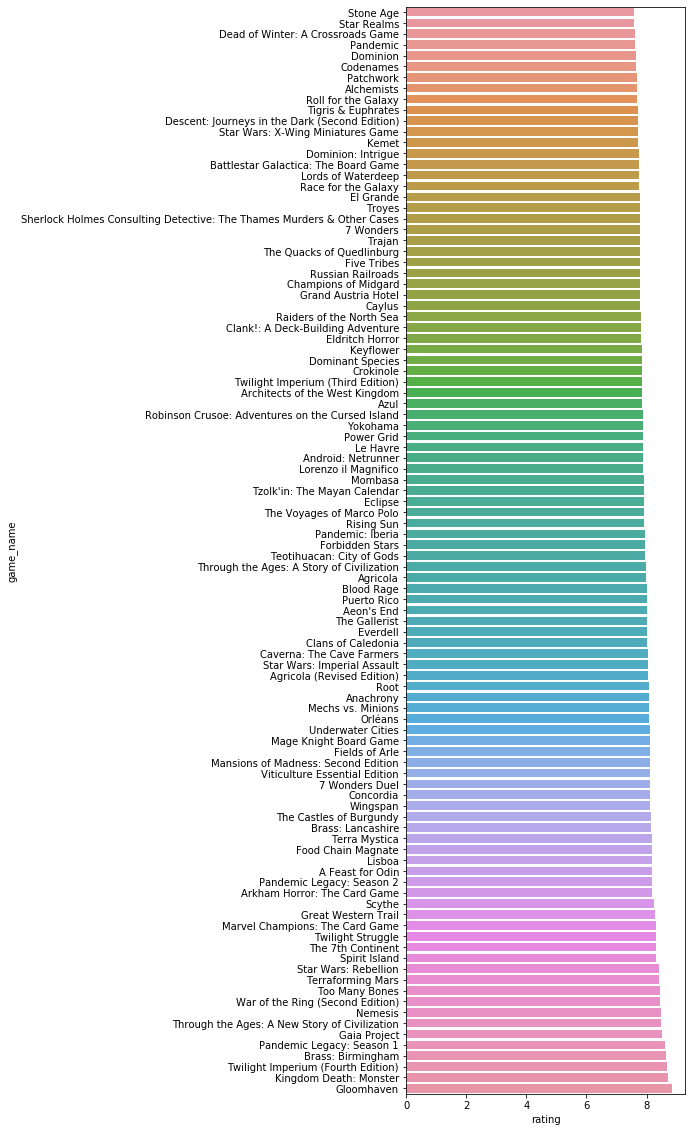

In [33]:
plt.figure(figsize = (5,20))
sns.barplot(x = avg_ratings_by_game, y = avg_ratings_by_game.index)
plt.show()

This average rating will be used in the prediction function, saving it for later. 

In [16]:
with open('./results/average_game_ratings.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerows(zip(avg_ratings_by_game.index, avg_ratings_by_game))

In [35]:
total_ratings_by_game = df.groupby('game_name').count()['rating'].copy()
total_ratings_by_game.sort_values(inplace = True)

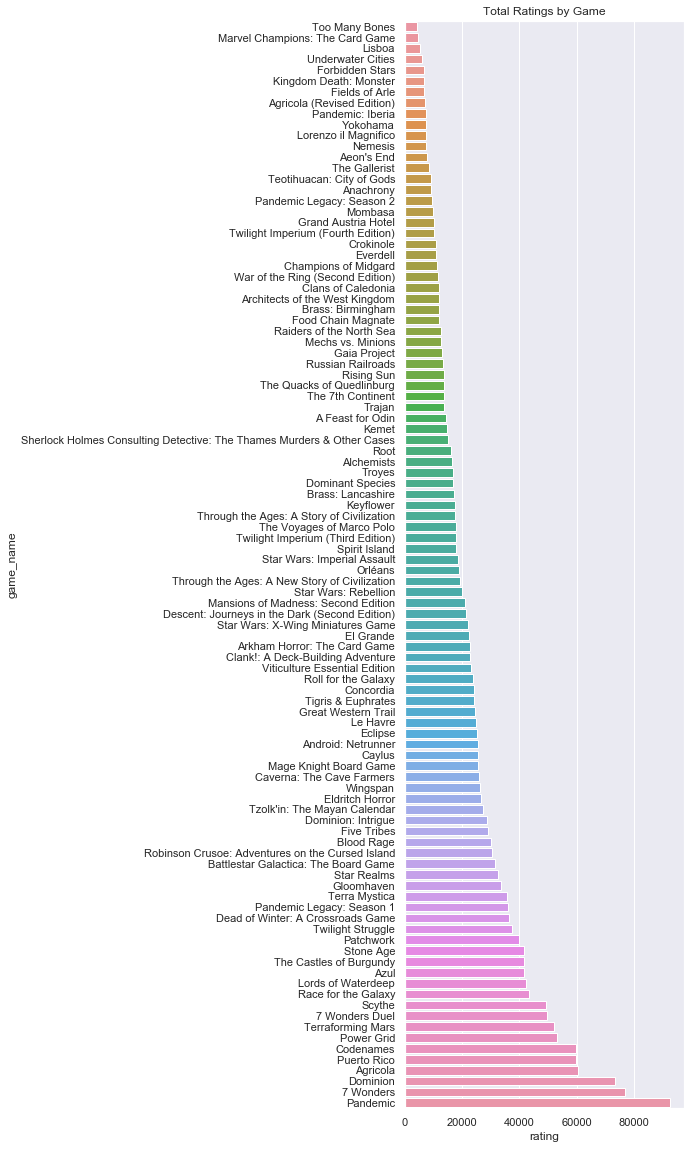

In [79]:
plt.figure(figsize = (5,20))
sns.barplot(x = total_ratings_by_game, y = total_ratings_by_game.index)
plt.title('Total Ratings by Game')
plt.show()

In [39]:
total_ratings_by_game.tail(10)

game_name
Scythe               49170
7 Wonders Duel       49680
Terraforming Mars    52092
Power Grid           53241
Codenames            59704
Puerto Rico          59772
Agricola             60362
Dominion             73197
7 Wonders            76854
Pandemic             92580
Name: rating, dtype: int64

In [40]:
total_ratings_by_game.head(10)

game_name
Too Many Bones                     4292
Marvel Champions: The Card Game    4717
Lisboa                             5505
Underwater Cities                  6210
Forbidden Stars                    6825
Kingdom Death: Monster             6847
Fields of Arle                     6938
Agricola (Revised Edition)         7040
Pandemic: Iberia                   7342
Yokohama                           7429
Name: rating, dtype: int64

## by User

A similar analysis, just by users this time.

In [5]:
avg_ratings_by_user = df.groupby('user_name').mean()['rating'].copy()
avg_ratings_by_user.sort_values(inplace = True)

In [6]:
avg_ratings_by_user_breakpoints = [0, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10]
avg_ratings_by_user_grouped = {}

for index in range(1, len(avg_ratings_by_user_breakpoints)):
    avg_ratings_by_user_grouped[
        str(avg_ratings_by_user_breakpoints[index - 1]) + \
        ' - ' + \
        str(avg_ratings_by_user_breakpoints[index])
    ] = \
        len(avg_ratings_by_user[
            (avg_ratings_by_user > avg_ratings_by_user_breakpoints[index - 1]) & \
            (avg_ratings_by_user <= avg_ratings_by_user_breakpoints[index])
        ])

In [7]:
avg_ratings_by_user_grouped

{'0 - 1.5': 281,
 '1.5 - 2.5': 182,
 '2.5 - 3.5': 307,
 '3.5 - 4.5': 490,
 '4.5 - 5.5': 1356,
 '5.5 - 6.5': 5749,
 '6.5 - 7.5': 34020,
 '7.5 - 8.5': 105508,
 '8.5 - 9.5': 64054,
 '9.5 - 10': 25297}

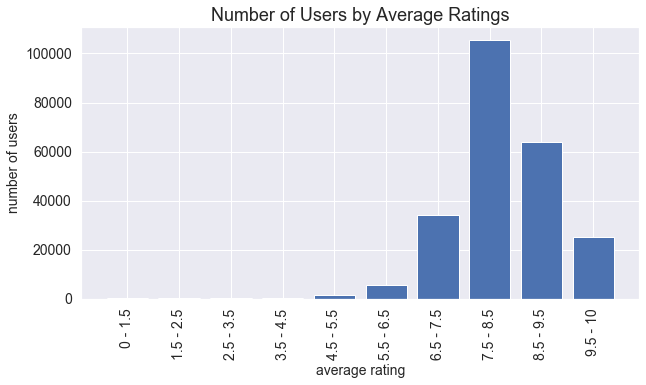

In [24]:
plt.figure(figsize=(10,5))
plt.bar(avg_ratings_by_user_grouped.keys(), avg_ratings_by_user_grouped.values())
plt.tick_params(axis = 'x', labelsize = 14, rotation = 90)
plt.tick_params(axis = 'y', labelsize = 14)
plt.xlabel('average rating', fontsize = 14)
plt.ylabel('number of users', fontsize = 14)
plt.title('Number of Users by Average Ratings', fontsize = 18)
plt.savefig('./charts/number_of_users_by_avg_ratings.png')
plt.show()



In [26]:
total_ratings_by_user = df.groupby('user_name').count()['rating'].copy()
total_ratings_by_user.sort_values(inplace = True)

In [27]:
total_ratings_by_user_breakpoints = [0, 1, 3, 6, 10, 20, 40, 100]
total_ratings_by_user_grouped = {}

for index in range(1, len(total_ratings_by_user_breakpoints)):
    total_ratings_by_user_grouped[
        str(total_ratings_by_user_breakpoints[index - 1]) + \
        ' - ' + \
        str(total_ratings_by_user_breakpoints[index])
    ] = \
        len(total_ratings_by_user[
            (total_ratings_by_user > total_ratings_by_user_breakpoints[index - 1]) & \
            (total_ratings_by_user <= total_ratings_by_user_breakpoints[index])
        ])

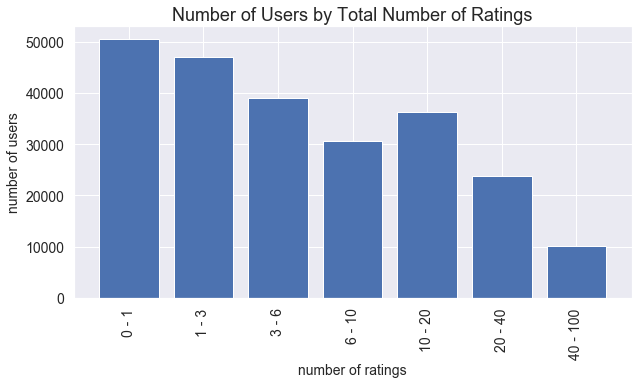

In [28]:
plt.figure(figsize=(10,5))
plt.bar(total_ratings_by_user_grouped.keys(), total_ratings_by_user_grouped.values())
plt.tick_params(axis = 'x', labelsize = 14, rotation = 90)
plt.tick_params(axis = 'y', labelsize = 14)
plt.xlabel('number of ratings', fontsize = 14)
plt.ylabel('number of users', fontsize = 14)
plt.title('Number of Users by Total Number of Ratings', fontsize = 18)
plt.savefig('./charts/number_of_users_by_number_of_ratings.png')
plt.show()



# Predictions

In this section, we create two different prediction functionalities. 

## Close Neighbors to One Game

First approach is quite simple. There are three different distance metrics, we are going to use pearson, which gave the highest results, and list the games by similarity based on that metric. 

In [113]:
similar_games_pearson_df = pd.read_csv('./results/top_10_similar_games_pearson.csv')

In [114]:
game_to_recommend_1 = 'Pandemic'

In [115]:
similar_games_pearson_df[similar_games_pearson_df['game'] == game_to_recommend_1]

,game,similar_1,similar_2,similar_3,similar_4,similar_5,similar_6,similar_7,similar_8,similar_9,similar_10
55,Pandemic,Pandemic: Iberia,Pandemic Legacy: Season 1,Dead of Winter: A Crossroads Game,Pandemic Legacy: Season 2,Robinson Crusoe: Adventures on the Cursed Island,Raiders of the North Sea,Lords of Waterdeep,Stone Age,Eldritch Horror,Mechs vs. Minions


In [118]:
game_to_recommend_2 = 'Mechs vs. Minions'

In [119]:
similar_games_pearson_df[similar_games_pearson_df['game'] == game_to_recommend_2]

,game,similar_1,similar_2,similar_3,similar_4,similar_5,similar_6,similar_7,similar_8,similar_9,similar_10
51,Mechs vs. Minions,Pandemic: Iberia,Too Many Bones,Star Wars: Imperial Assault,Aeon's End,Nemesis,Anachrony,Gloomhaven,The 7th Continent,Pandemic Legacy: Season 2,Descent: Journeys in the Dark (Second Edition)


In [121]:
game_to_recommend_3 = 'Gloomhaven'

In [122]:
similar_games_pearson_df[similar_games_pearson_df['game'] == game_to_recommend_3]

,game,similar_1,similar_2,similar_3,similar_4,similar_5,similar_6,similar_7,similar_8,similar_9,similar_10
38,Gloomhaven,Mechs vs. Minions,The 7th Continent,Kingdom Death: Monster,Spirit Island,Too Many Bones,Pandemic Legacy: Season 1,Mage Knight Board Game,Star Wars: Imperial Assault,Aeon's End,Pandemic Legacy: Season 2


## kNN with Means Estimation

In this section, user can enter a list of scores, we estimate the scores of the remaining games. Once that is done, we sort the estimated ratings, and list the most / least similar games. 

In [29]:
pearson_distances = pd.read_csv('./results/pearson_distances.csv', header = None)
distance_matrix_gamelist = pd.read_csv('./results/game_ids_for_distance_matrix.csv', header = None)
distance_matrix_gamelist[0] = distance_matrix_gamelist[0].map(name_converter.get_game_name_from_id)
pearson_distances.columns = distance_matrix_gamelist[0]
pearson_distances.index = distance_matrix_gamelist[0]

average_ratings_by_game = pd.read_csv('./results/average_game_ratings.csv', header = None)
average_ratings_by_game.set_index(0, inplace = True);
average_ratings_by_game.columns = ['rating']

recommender = kNNMeans_Recommender(pearson_distances, average_ratings_by_game)

In [5]:
user_input = {
    'Gloomhaven': 8,
    'Concordia': 5,
    'Brass: Lancashire': 1,
    'Mage Knight Board Game' : 10
}

estimated_ratings = recommender.estimate_all_for_user(user_input)
sorted_ratings = sorted(estimated_ratings.items(), key=lambda x: x[1])
sorted_ratings[-10:]

[('Mechs vs. Minions', 6.451816143694341),
 ('Through the Ages: A New Story of Civilization', 6.456851763625423),
 ('War of the Ring (Second Edition)', 6.574370275753605),
 ('Star Wars: Rebellion', 6.611829277541821),
 ('Spirit Island', 6.713409093776129),
 ('The 7th Continent', 6.772269713062598),
 ('Too Many Bones', 6.775541610558201),
 ('Kingdom Death: Monster', 6.805056811171298),
 ('Twilight Imperium (Fourth Edition)', 6.901768857664621),
 ('Pandemic Legacy: Season 1', 6.948126070990531)]

In [7]:
sorted_ratings[:10]

[('Tigris & Euphrates', 4.375908127876405),
 ('Power Grid', 4.601068624654035),
 ('Caylus', 4.660816172074577),
 ('El Grande', 4.677011155605624),
 ('Le Havre', 4.852901787515467),
 ('Puerto Rico', 4.866252354105704),
 ('Brass: Birmingham', 4.901483527551557),
 ('Azul', 4.920245866365978),
 ('Yokohama', 4.9358482684793366),
 ('Troyes', 4.954212561157438)]

In [8]:
user_input = {
    'Gloomhaven': 10,
    'Terra Mystica': 8,
    'Pandemic Legacy: Season 1': 10,
    'Pandemic Legacy: Season 2': 10,
    'Le Havre': 4,
    '7 Wonders Duel': 5
}

estimated_ratings = recommender.estimate_all_for_user(user_input)
sorted_ratings = sorted(estimated_ratings.items(), key=lambda x: x[1])
sorted_ratings[-10:]

[('Brass: Birmingham', 8.030901662575857),
 ('Gaia Project', 8.035843237326675),
 ('Marvel Champions: The Card Game', 8.104832888920479),
 ('Star Wars: Rebellion', 8.192908651851832),
 ('Spirit Island', 8.211925513500049),
 ('The 7th Continent', 8.251594910174413),
 ('Too Many Bones', 8.319890362483607),
 ('Nemesis', 8.56479184258484),
 ('Twilight Imperium (Fourth Edition)', 8.650063052312504),
 ('Kingdom Death: Monster', 8.755304968812336)]

In [11]:
sorted_ratings[:10]

[('Caylus', 6.353596197102511),
 ('Stone Age', 6.489938538379176),
 ('Troyes', 6.564641813076644),
 ('Tigris & Euphrates', 6.608647608765206),
 ('El Grande', 6.628869161908035),
 ('Puerto Rico', 6.633773956177026),
 ('Power Grid', 6.698738998085723),
 ('Patchwork', 6.75768415768203),
 ('Race for the Galaxy', 6.778220349199778),
 ('Dominant Species', 6.781566247101862)]

In [30]:
user_input = {
    'Le Havre': 8,
    'Concordia': 9,
    'The Castles of Burgundy': 8,
    'Mansions of Madness: Second Edition': 5,
    'Kingdom Death: Monster':6
}

estimated_ratings = recommender.estimate_all_for_user(user_input)
sorted_ratings = sorted(estimated_ratings.items(), key=lambda x: x[1])
sorted_ratings[-10:]

[('Agricola', 7.436929246134879),
 ('Agricola (Revised Edition)', 7.456466489174002),
 ('Through the Ages: A New Story of Civilization', 7.46818223297934),
 ('Orléans', 7.4808225652209),
 ('Terra Mystica', 7.498203401133102),
 ('Terraforming Mars', 7.5063889188525685),
 ('Gaia Project', 7.621611348138763),
 ('Puerto Rico', 7.665136353318606),
 ('Great Western Trail', 7.786750410443334),
 ('Brass: Birmingham', 7.82265622044594)]

In [31]:
sorted_ratings[:10]

[('Dead of Winter: A Crossroads Game', 6.137392982038492),
 ('Eldritch Horror', 6.18219035784441),
 ('Descent: Journeys in the Dark (Second Edition)', 6.184951955219102),
 ('Battlestar Galactica: The Board Game', 6.251411498460326),
 ('Twilight Imperium (Third Edition)', 6.303007691141433),
 ('Star Wars: X-Wing Miniatures Game', 6.351820265127011),
 ('Rising Sun', 6.404793619155726),
 ('Sherlock Holmes Consulting Detective: The Thames Murders & Other Cases',
  6.490779702714515),
 ('Star Realms', 6.5148750684520245),
 ('Star Wars: Imperial Assault', 6.516697941797345)]